## Generalized Synthetic Control Method: Causal Inference with Instrumented Principal Component Analysis
`Cong Wang`

### 1. Framework
---
+ $Y_{it}$ is the outcome.

+ Total number of units $N=N_{co} + N_{tr}$

+ Total number of time periods $T=T_0 + T_1$

+ Staggered treatment adoption

`Assumption 1.` Functional form:

\begin{equation}
\begin{align*}

&Y_{it} = D_{it} \circ \delta_{it} + \beta'_{it}F_{t} + \epsilon_{it}, \\
&\beta_{it} = x'_{it}\Gamma + \eta_{it}

\end{align*}
\end{equation}


+ $D_{it}$ indicates units with or without treatment

+ $\delta_{it}$ indicates treatment heterogeneity is allowed (across units and periods)

+ $x_{it}$ contains $L\times 1$ vector of observed covariates

+ $\Gamma$ is a $L\times K$ transforming matrix

+ $\beta_{it}$ is a $K\times 1$ unknown factors, it is constant across units and periods

+ $F_t$ is a $K\times 1$ unobserved common factors

+ $\beta'_{it}F_{t}$ is the factor component

In [4]:
import pandas as pd
import numpy as np
import scipy.linalg as sla
import scipy.sparse.linalg as ssla

import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### 2. Data generating process

In [5]:
# matrix left/right division (following MATLAB function naming)
_mldivide = lambda denom, numer: sla.lstsq(np.array(denom), np.array(numer))[0]
_mrdivide = lambda numer, denom: (sla.lstsq(np.array(denom).T, np.array(numer).T)[0]).T

### with the data simulated by (Xu 2017)

In [6]:
data = pd.read_csv('data/yiqing_simdata.csv', index_col=0)
data['tr_group'] = data.groupby('id').D.transform('max')
data['post_period'] = data.groupby('time').D.transform('max')
data = data[['id', 'time', 'Y', 'tr_group', 'post_period', 'X1', 'X2', 'eff']]

In [7]:
T0 = data.query("post_period==0").time.max()
T1 = data.query("post_period==1").time.max() - T0
N_co = data.query("tr_group==0").id.nunique()
N_tr = data.query("tr_group==1").id.nunique()

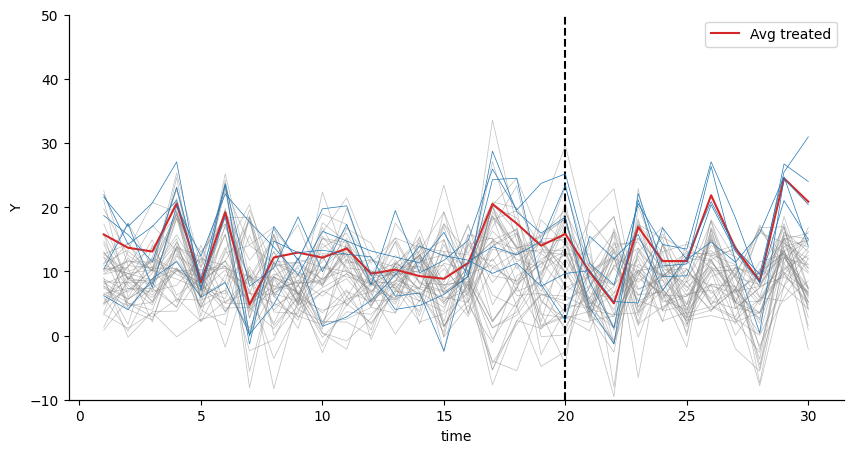

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==0"), ax=ax, legend=False)
for line in ax.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])

ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(data.query("tr_group==1").groupby('time').Y.mean(), color=colors[3], label='Avg treated')
ax.legend()
ax.set(ylim=(-10, 50))

ax2 = ax.twinx()
sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==1"), ax=ax2, legend=False)
for line in ax2.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax2.set(ylim=(-10, 50))
ax2.yaxis.set_visible(False)

sns.despine()

In [9]:
# prepare contorl data for estimation--Gamma, F
Y0 = np.array(data.query("tr_group==0").pivot(index='id', columns='time', values='Y'))
X0 = np.empty((N_co, T0+T1, 2))
for t in range(0, T0+T1):
    X0[:, t, 0] = data.query(f"(tr_group==0) & (time=={t+1})").X1
    X0[:, t, 1] = data.query(f"(tr_group==0) & (time=={t+1})").X2

In [10]:
# K: number of factors
K = 6
# L: number of covariates
L = 2

# step 1: initial guess
svU, svS, svV = ssla.svds(Y0, K)
svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV) # reverse order to match MATLAB svds output
# initial guess for factors
F0 = np.diag(svS) @ svV
gamma0 = np.random.normal(0, 1, size=(L, K))

def als_est(F0):
    # step L: compute Gamma, 
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T0+T1):
        ft_slice = F0[:, t]  # Kx1 for each t
        for i in range(N_co):
            X0_slice = X0[i, t, :]  # Lx1 for each i, t
            # Compute Kronecker product
            kron_prod = np.kron(X0_slice, ft_slice)
            # Update denom and numer
            denom += np.outer(kron_prod, kron_prod)
            numer += kron_prod * Y0[i, t]

    # Solve for Gamma using the computed matrices
    gamma_hat = _mldivide(denom, numer)

    # Reshape gamma_hat if necessary to match the expected dimensions of Gamma
    gamma1 = gamma_hat.reshape(L, K)

    # step 3: update F
    F1 = np.zeros((K, T0+T1))
    for t in range(T0+T1):
        denom = gamma1.T@X0[:,t,:].T@X0[:,t,:]@gamma1
        numer = gamma1.T@X0[:,t,:].T@Y0[:,t]
        F1[:, t] = _mldivide(denom, numer)
    return F1, gamma1

# step 4: ALS estimate
MaxIter, MinTol = 100, 1e-6
tol, iter = float('inf'), 0
while iter < MaxIter and tol > MinTol:
    F1, gamma1 = als_est(F0)
    tol_gamma = abs(gamma1 - gamma0).max()
    tol_F = abs(F1 - F0).max()
    tol = max(tol_gamma, tol_F)
    print('iter {}: tolGamma = {} and tolFac = {}'.format(iter, tol_gamma, tol_F))
    F0, gamma0 = F1, gamma1
    iter += 1

iter 0: tolGamma = 1.6654813350876894 and tolFac = 82.69664704389703
iter 1: tolGamma = 0.03720192349182154 and tolFac = 62.50073656942115
iter 2: tolGamma = 0.13313112664669255 and tolFac = 47.40871964806564
iter 3: tolGamma = 0.03858271699749198 and tolFac = 22.862834620750252
iter 4: tolGamma = 0.09888979097578225 and tolFac = 17.583715349243217
iter 5: tolGamma = 0.1031602278956737 and tolFac = 7.609300890049262
iter 6: tolGamma = 0.3172392047834172 and tolFac = 18.33555456960112
iter 7: tolGamma = 0.4255945523215817 and tolFac = 4.544966589261174
iter 8: tolGamma = 1.1313027315675084 and tolFac = 7.991676241683936
iter 9: tolGamma = 1.851306614725592 and tolFac = 4.743501899930237
iter 10: tolGamma = 2.7400304247748863e-13 and tolFac = 1.1302070390684094e-13


In [11]:
Y_hat = np.zeros((N_co, T0+T1))
for i in range(T0+T1):
    for n in range(N_co):
        Y_hat[n, i] = X0[n, i, :]@gamma1@F1[:, t]

In [12]:
def _calc_r2(r_act, r_fit):
    '''
    compute r2 of fitted values vs actual
    '''
    sumsq = lambda x: x.dot(x)
    sse = sumsq(r_act.flatten() - r_fit.flatten())
    sst = sumsq(r_act.flatten())
    return 1. - sse / sst

In [13]:
_calc_r2(Y0, Y_hat)

0.8733809281939393

In [14]:
# prepare contorl data for estimation--Gamma, F
Y10 = np.array(data.query("tr_group==1 & post_period==0").pivot(index='id', columns='time', values='Y'))
X10 = np.empty((N_tr, T0, 2))
for t in range(0, T0):
    X10[:, t, 0] = data.query(f"(tr_group==1) & (time=={t+1})").X1
    X10[:, t, 1] = data.query(f"(tr_group==1) & (time=={t+1})").X2

In [15]:
# compute the gamma for treated units
vec_len = 2*K
numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
for t in range(T0):
    ft_slice = F1[:, t]  # Kx1 for each t
    for i in range(N_tr):
        X10_slice = X10[i, t, :]  # Lx1 for each i, t
        # Compute Kronecker product
        kron_prod = np.kron(X10_slice, ft_slice)
        # Update denom and numer
        denom += np.outer(kron_prod, kron_prod)
        numer += kron_prod * Y10[i, t]
# Solve for Gamma using the computed matrices
gamma_hat = _mldivide(denom, numer)
gamma_hat = gamma_hat.reshape(2, K)

In [16]:
X1 = np.empty((N_tr, T0+T1, 2))
for t in range(0, T0+T1):
    X1[:, t, 0] = data.query(f"(tr_group==1) & (time=={t+1})").X1
    X1[:, t, 1] = data.query(f"(tr_group==1) & (time=={t+1})").X2
Y_syn = np.zeros((N_tr, T0+T1))
for t in range(T0+T1):
    for n in range(N_tr):
        Y_syn[n, t] = X1[n, t, :]@gamma_hat@F1[:, t]

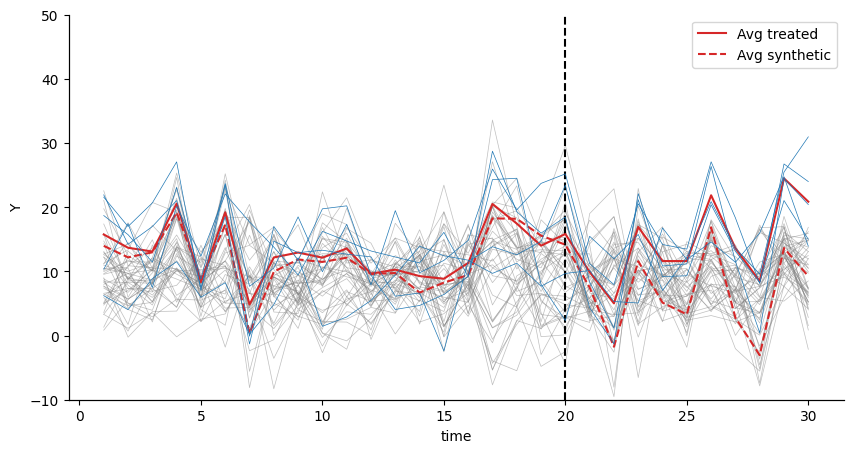

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==0"), ax=ax, legend=False)
for line in ax.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(data.query("tr_group==1").groupby('time').Y.mean(), color=colors[3], label='Avg treated')
ax.legend()
ax.set(ylim=(-10, 50))

sns.lineplot(y=Y_syn.mean(axis=0), x=np.arange(1, T0+T1+1), color=colors[3], linestyle='--', label='Avg synthetic')

ax2 = ax.twinx()
sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==1"), ax=ax2, legend=False)
for line in ax2.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax2.set(ylim=(-10, 50))
ax2.yaxis.set_visible(False)

sns.despine()

In [18]:
# compute the residuals between the synthetic control and the treated units
residuals = np.mean(data.query("tr_group==1").pivot(index='id', columns='time', values='Y')-Y_syn, axis=0)
# true treatment effect
eff = data.query("tr_group==1").groupby('time').eff.mean()

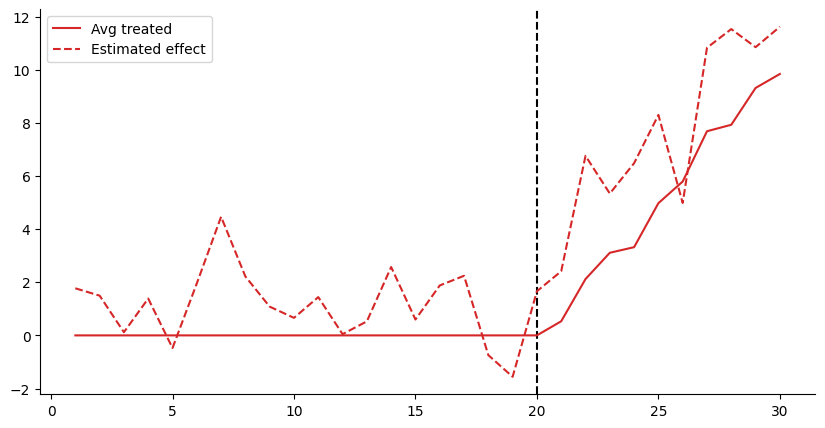

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(eff, color=colors[3], label='Avg treated')
ax.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax.legend()

sns.despine()

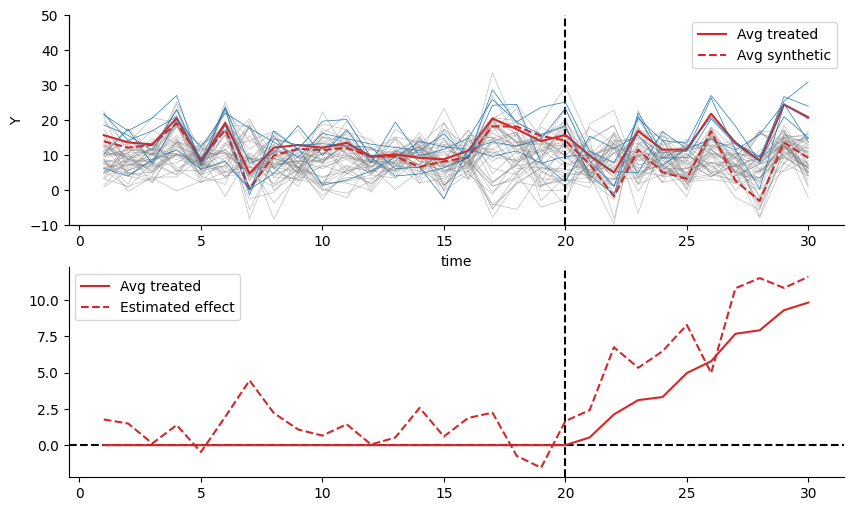

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==0"), ax=ax1, legend=False)
for line in ax1.lines:
    line.set_linewidth(0.5)
    line.set_alpha(0.5)
    line.set_color(colors[7])
ax1.axvline(x=T0, color='black', linestyle='--')
ax1.plot(data.query("tr_group==1").groupby('time').Y.mean(), color=colors[3], label='Avg treated')
ax1.legend()
ax1.set(ylim=(-10, 50))

sns.lineplot(y=Y_syn.mean(axis=0), x=np.arange(1, T0+T1+1), color=colors[3], linestyle='--', label='Avg synthetic', ax=ax1)

ax11 = ax1.twinx()
sns.lineplot(x='time', y='Y', hue='id', data=data.query("tr_group==1"), ax=ax11, legend=False)
for line in ax11.lines:
    line.set_linewidth(0.5)
    line.set_alpha(1)
    line.set_color(colors[0])
ax11.set(ylim=(-10, 50))
ax11.yaxis.set_visible(False)

ax2.axvline(x=T0, color='black', linestyle='--')
ax2.axhline(y=0, color='black', linestyle='--')
ax2.plot(eff, color=colors[3], label='Avg treated')
ax2.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax2.legend()

sns.despine()

### Monte Carlo simulation

\begin{equation}
Y_{it} = D_{it} \circ \delta_{it} + (X_{it}\Gamma) F_{t} + \epsilon_{it}, \quad \epsilon_{it} = \mu_{it} + H_{it}F_t.
\tag{2}
\end{equation}

In [22]:
def generate_stationary_AR1(n):
    """
    Generate a random n x n matrix A1 for a VAR(1) process
    that satisfies the stationarity condition (all eigenvalues lie inside the unit circle).
    """
    while True:
        # Generate a random matrix
        A1 = np.random.rand(n, n) - 0.5  # Shift to have negative and positive values
        # Check if the generated matrix satisfies the stationarity condition
        eigenvalues = np.linalg.eigvals(A1)
        if np.all(np.abs(eigenvalues) < 1):
            return A1

In [23]:
# Number of factors and time periods
K = 3
T0 = 20
T1 = 10
L = 10
N_co = 45
N_tr = 5

# Factors for VAR(1) process
# Assuming a simple structure where each variable depends on its own and the other variable's past value
A = generate_stationary_AR1(K)
# Initial values for the first period are drawn from a normal distribution
F = np.zeros((K, T0+T1))
F[:, 0] = np.random.normal(size=K)
# Generate the time series
for t in range(1, T0+T1):
    F[:, t] = A @ F[:, t-1] + np.random.normal(size=K)

# Covariates for VAR(1) process
# Assuming a simple structure where each variable depends on its own and the other variable's past value
B = np.zeros((N_co+N_tr, L, L))
for i in range(N_co+N_tr):
    B[i, :, :] = generate_stationary_AR1(L)
# Initial values for the first period are drawn from a normal distribution
X = np.zeros((N_co+N_tr, T0+T1, L))
X[:, 0, :] = np.random.normal(0, 1, size=(N_co+N_tr, L))

# Generate the time series for control units
for i in range(N_co):
    for t in range(1, T0+T1):
         X[i, t, :] = B[i, :, :] @ X[i, t-1, :] + np.random.normal(size=L)
# Generate the time series for treated units with a drift
for i in range(N_tr):
    for t in range(1, T0+T1):
         X[-i, t, :] = B[-i, :, :] @ X[-i, t-1, :] + np.random.normal(2, 1, size=L)

# Generate Gama
Gama = np.random.uniform(0, 0.1, size=(L, K))

# Generate coefficient Lambda, unit fixed effect alpha, time fixed effect xi
Lamda = np.random.uniform(0, 1, L)
alpha = np.random.uniform(0, 1, N_co+N_tr)
xi = np.random.uniform(0, 1, T0+T1)

# Generate outcome variable
Y = np.zeros((N_co+N_tr, T0+T1))
for t in range(T0+T1):
    for i in range(N_co+N_tr):
        Y[i, t] = X[i, t, :] @ Gama @ F[:, t] + np.random.normal()
        Y[i, t] += X[i, t, :] @ Lamda
        Y[i, t] += alpha[i] + xi[t]

# Treatment effects and assignment
tr = np.concatenate([np.zeros(N_co), np.ones(N_tr)])
delta = np.concatenate([np.zeros(T0), np.arange(1, T1+1) + np.random.normal(0, 1, T1)]) 
Y += tr.reshape(-1,1) @ delta.reshape(1, -1)

# Construct DataFrame
df = pd.DataFrame({
    'id': np.repeat(np.arange(101, N_co+N_tr + 101), T0+T1),
    'year': np.tile(np.arange(1, T0+T1 + 1), N_co+N_tr),
    'y': Y.flatten(),
    'd': np.repeat(tr, T0+T1),
    'x1': X[:,:,0].flatten(),
    'x2': X[:,:,1].flatten(),
    'x3': X[:,:,2].flatten(),
    'x4': X[:,:,3].flatten(),
    'x5': X[:,:,4].flatten(),
    'x6': X[:,:,5].flatten(),
    'x7': X[:,:,6].flatten(),
    'x8': X[:,:,7].flatten(),
    'x9': X[:,:,8].flatten(),
    'x10': X[:,:,9].flatten(),
    'eff': np.tile(delta, N_co+N_tr)
    })

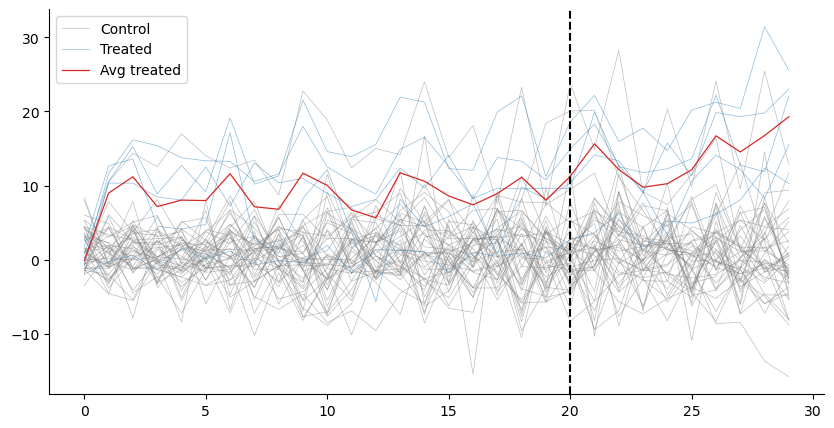

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot for control group with a specific color
for i in range(N_co):
    sns.lineplot(data=Y[i, :], legend=False, ax=ax, color=colors[7], linewidth=0.5, alpha=0.5, label='Control' if i==0 else None)

# Plot for treatment group with another color
for i in range(N_tr):
    sns.lineplot(data=Y[-(i+1), :], legend=False, ax=ax, color=colors[0], linewidth=0.5, alpha=0.5, label='Treated' if i==0 else None)

sns.lineplot(data=Y[-N_tr:, :].mean(axis=0), ax=ax, color=colors[3], label='Avg treated', linewidth=0.9)
ax.axvline(x=T0, color='black', linestyle='--')
sns.despine()

In [40]:
Y0 = Y[:N_co, :]
X0 = X[:N_co, :, :]

In [41]:
# K: number of factors
K = 3
# L: number of covariates
L = 10

# step 1: initial guess
svU, svS, svV = ssla.svds(Y0, K)
svU, svS, svV = np.fliplr(svU), svS[::-1], np.flipud(svV) # reverse order to match MATLAB svds output
# initial guess for factors
F0 = np.diag(svS) @ svV
gamma0 = np.random.normal(0, 1, size=(L, K))

def als_est(F0):
    # step L: compute Gamma, 
    vec_len = L*K
    numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
    for t in range(T0+T1):
        ft_slice = F0[:, t]  # Kx1 for each t
        for i in range(N_co):
            X0_slice = X0[i, t, :]  # Lx1 for each i, t
            # Compute Kronecker product
            kron_prod = np.kron(X0_slice, ft_slice)
            # Update denom and numer
            denom += np.outer(kron_prod, kron_prod)
            numer += kron_prod * Y0[i, t]

    # Solve for Gamma using the computed matrices
    gamma_hat = _mldivide(denom, numer)

    # Reshape gamma_hat if necessary to match the expected dimensions of Gamma
    gamma1 = gamma_hat.reshape(L, K)

    # step 3: update F
    F1 = np.zeros((K, T0+T1))
    for t in range(T0+T1):
        denom = gamma1.T@X0[:,t,:].T@X0[:,t,:]@gamma1
        numer = gamma1.T@X0[:,t,:].T@Y0[:,t]
        F1[:, t] = _mldivide(denom, numer)
    return F1, gamma1

# step 4: ALS estimate
MaxIter, MinTol = 100, 1e-6
tol, iter = float('inf'), 0
while iter < MaxIter and tol > MinTol:
    F1, gamma1 = als_est(F0)
    tol_gamma = abs(gamma1 - gamma0).max()
    tol_F = abs(F1 - F0).max()
    tol = max(tol_gamma, tol_F)
    print('iter {}: tolGamma = {} and tolFac = {}'.format(iter, tol_gamma, tol_F))
    F0, gamma0 = F1, gamma1
    iter += 1

iter 0: tolGamma = 2.0750477024763954 and tolFac = 134.55878428355052
iter 1: tolGamma = 0.0015666476975416468 and tolFac = 23.12491586723437
iter 2: tolGamma = 0.0013544752444864454 and tolFac = 21.00421445080111
iter 3: tolGamma = 0.0012665920005947213 and tolFac = 13.003263014117813
iter 4: tolGamma = 0.001042089472348041 and tolFac = 12.396976799164893
iter 5: tolGamma = 0.0007449425093591982 and tolFac = 12.119088648422691
iter 6: tolGamma = 0.0005655182331652576 and tolFac = 13.017273083935772
iter 7: tolGamma = 0.0005050428078034169 and tolFac = 14.727588724895085
iter 8: tolGamma = 0.0005417468415530374 and tolFac = 15.46636821214468
iter 9: tolGamma = 0.000570174803906023 and tolFac = 12.97761408488146
iter 10: tolGamma = 0.0005081127041089775 and tolFac = 8.005691124222864
iter 11: tolGamma = 0.0003793361688765231 and tolFac = 4.550425175982376
iter 12: tolGamma = 0.000256014796763843 and tolFac = 3.144950791136843
iter 13: tolGamma = 0.00016769167325844485 and tolFac = 2.184

In [42]:
Y_hat = np.zeros((N_co, T0+T1))
for i in range(T0+T1):
    for n in range(N_co):
        Y_hat[n, i] = X0[n, i, :]@gamma1@F1[:, t]

In [43]:
Y10 = Y[-N_tr:, :T0]
X10 = X[-N_tr:, :T0, :]

In [44]:
# compute the gamma for treated units
vec_len = L*K
numer, denom = np.zeros(vec_len), np.zeros((vec_len, vec_len))
for t in range(T0):
    ft_slice = F1[:, t]  # Kx1 for each t
    for i in range(N_tr):
        X10_slice = X10[i, t, :]  # Lx1 for each i, t
        # Compute Kronecker product
        kron_prod = np.kron(X10_slice, ft_slice)
        # Update denom and numer
        denom += np.outer(kron_prod, kron_prod)
        numer += kron_prod * Y10[i, t]
# Solve for Gamma using the computed matrices
gamma_hat = _mldivide(denom, numer)
gamma_hat = gamma_hat.reshape(L, K)

In [45]:
X1 = X[-N_tr:, :, :]

Y_syn = np.zeros((N_tr, T0+T1))
for t in range(T0+T1):
    for n in range(N_tr):
        Y_syn[n, t] = X1[n, t, :]@gamma_hat@F1[:, t]

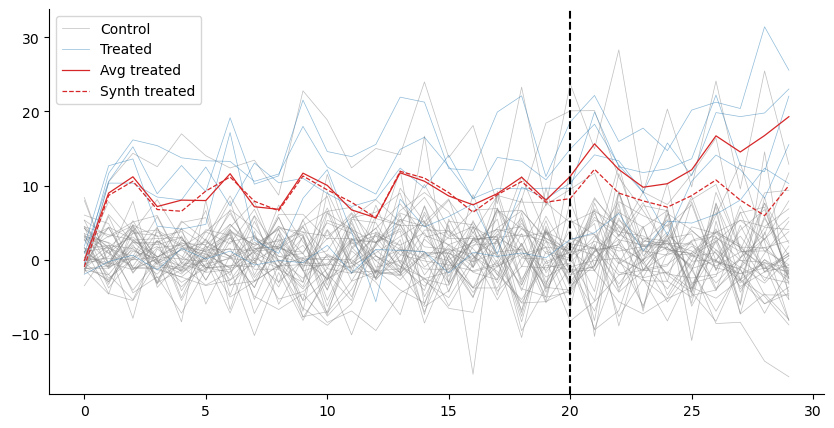

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot for control group with a specific color
for i in range(N_co):
    sns.lineplot(data=Y[i, :], legend=False, ax=ax, color=colors[7], linewidth=0.5, alpha=0.5, label='Control' if i==0 else None)

# Plot for treatment group with another color
for i in range(N_tr):
    sns.lineplot(data=Y[-(i+1), :], legend=False, ax=ax, color=colors[0], linewidth=0.5, alpha=0.5, label='Treated' if i==0 else None)

sns.lineplot(data=Y[-N_tr:, :].mean(axis=0), ax=ax, color=colors[3], label='Avg treated', linewidth=0.9)
sns.lineplot(data=Y_syn.mean(axis=0), ax=ax, color=colors[3], label='Synth treated', linewidth=0.9, linestyle='--')

ax.axvline(x=T0, color='black', linestyle='--')
sns.despine()

In [47]:
# compute the residuals between the synthetic control and the treated units
residuals = np.mean(Y[-N_tr:, :]-Y_syn, axis=0)
# true treatment effect is delta

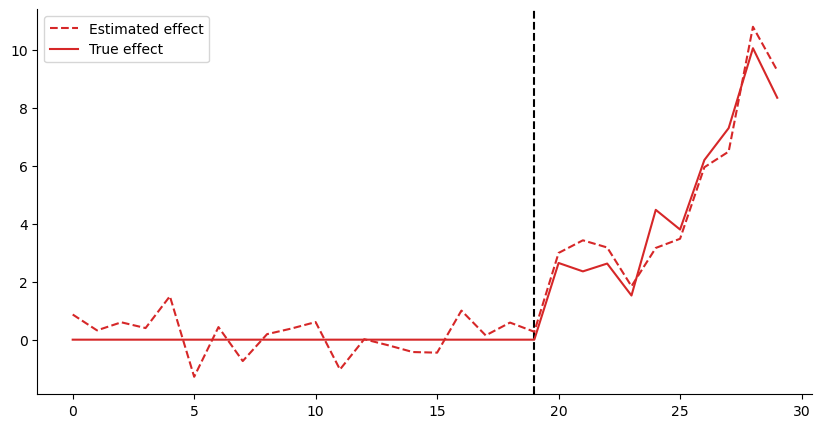

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.axvline(x=T0-1, color='black', linestyle='--')
ax.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax.plot(delta, color=colors[3], label='True effect')

ax.legend()

sns.despine()

In [15]:
# write a functin to estimate beta F, L
def estimate_parameters(Y, X, r, max_iter=1000, tol=1e-6):
    """
    Estimates parameters of the interactive fixed-effects model using an iterative procedure.
    
    Args:
    Y (np.array): Outcome variable (T, N).
    X (np.array): Regressors (p, T, N).
    r (int): Number of factors.
    max_iter (int): Maximum number of iterations.
    tol (float): Convergence tolerance level.
    
    Returns:
    np.array: Estimated beta coefficients (p, 1).
    np.array: Estimated factors F (T, r).
    np.array: Estimated loadings L (N, r).
    """
    p, N, T = X.shape

    # Reshape Y and X for matrix operations
    y = Y.reshape(N*T, 1, order='F')
    x = X.reshape(p, N*T, order='A').T

    # Initialize parameters
    F = np.random.randn(T, r)
    L = np.random.randn(N, r)

    prev_fun_value = 0
    # perform iterations
    for _ in range(max_iter):
        # compute beta
        beta = np.linalg.inv(x.T @ x) @ (x.T @ (y - (F@L.T).reshape(N*T,1)))

        # update F and L
        residual = (Y - (X.T@beta).reshape(T, N))
        M = (residual @ residual.T) / (N*T)
        s, v, d = np.linalg.svd(M)
        F = s[:, :r]
        L = residual.T @ F / T

        # compute the objective function
        obj_fun = np.sum((Y-(X.T@beta).reshape(T, N) - F@L.T).T @ (Y-(X.T@beta).reshape(T, N) - F@L.T)**2)
        # check for convergence
        if np.abs(obj_fun - prev_fun_value) < tol:
            break
        prev_fun_value = obj_fun
    return beta, F

In [16]:
# prepare contorl data for estimation--beta, F
Y0 = np.array(df.query("d==0").pivot(index='year', columns='id', values='y'))
X0 = np.empty((L, N_co, T0+T1))
for i in range(0, L):
    X0[i] = df.query("d==0").pivot(index='id', columns='year', values=f'x{i+1}')

In [17]:
# suppose we know the number of factors is L
beta, F = estimate_parameters(Y=Y0, X=X0, r=L, max_iter=1000, tol=1e-6)
beta

array([[0.53139598],
       [0.00196419],
       [0.63123921],
       [0.86555288],
       [0.1329804 ],
       [0.00644798],
       [0.78387819],
       [0.98930786],
       [0.92752325],
       [0.24581692]])

In [18]:
# prepare pre-treatment treated data for estimation -- L1(factor loading for treated units)
Y10 = np.array(df.query(f"d==1 & year<={T0}").pivot(index='year', columns='id', values='y'))
X10 = np.empty((L, N_tr, T0))
for i in range(0, L):
    X10[i] = df.query(f"d==1 & year<={T0}").pivot(index='id', columns='year', values=f'x{i+1}')
    
F0 = F[:T0, ]

In [19]:
# solve it by formula
L1 = np.linalg.inv(F0.T @ F0) @ F0.T @ (Y10 - (X10.T @ beta).reshape(T0, N_tr))
pd.DataFrame(L1)

,0,1,2,3,4
0,-2.125290,-8.231030,-4.121884,-5.264366,-5.792438
1,0.386779,-3.506083,-3.323098,-5.138391,-2.256821
2,-2.221630,-5.953250,-4.845121,-6.943467,-5.000538
3,-0.075708,-0.253215,1.422887,5.947347,6.616939
4,2.885226,1.344221,2.292954,4.123918,2.658497
5,-1.279660,-1.928259,-0.884000,-1.046358,-0.213424
6,-1.430492,-2.367615,0.901278,-3.844958,-1.627764
7,0.538769,1.929375,1.600751,-0.209149,-0.049596
8,-0.243657,-1.310224,0.112239,1.459507,-2.546751
9,-0.619887,1.496901,-3.407506,-4.675504,-0.957555


In [20]:
# or solve it by minimizing the objective function
import cvxpy as cp
T, N = Y10.shape
# create a cvxpy variable for L
L1_ = cp.Variable((N, L))
# define the objective function
obj_fun = cp.Minimize(cp.sum_squares(Y10 - (X10.T @ beta).reshape(T, N) - F0 @ L1_.T))
# define the problem and solve it
prob = cp.Problem(obj_fun)
prob.solve()

# print the results
pd.DataFrame(L1_.value.T)

,0,1,2,3,4
0,-2.125290,-8.231030,-4.121884,-5.264366,-5.792438
1,0.386779,-3.506083,-3.323098,-5.138391,-2.256821
2,-2.221630,-5.953250,-4.845121,-6.943467,-5.000538
3,-0.075708,-0.253215,1.422887,5.947347,6.616939
4,2.885226,1.344221,2.292954,4.123918,2.658497
5,-1.279660,-1.928259,-0.884000,-1.046358,-0.213424
6,-1.430492,-2.367615,0.901278,-3.844958,-1.627764
7,0.538769,1.929375,1.600751,-0.209149,-0.049596
8,-0.243657,-1.310224,0.112239,1.459507,-2.546751
9,-0.619887,1.496901,-3.407506,-4.675504,-0.957555


In [33]:
# reshape covariates X for treated units all time periods
X1 = np.empty((L, N_tr, T0+T1))
for i in range(0, L):
    X1[i] = df.query("d==1").pivot(index='id', columns='year', values=f'x{i+1}')

In [34]:
# compute counterfactual for treated units all time periods
Y_syn = (X1.T @ beta).reshape(T0+T1, N_tr) + F @ L1

In [35]:
# compute the residuals between the synthetic control and the treated units
residuals = np.mean(df.query("d==1").pivot(index='year', columns='id', values='y')-Y_syn, axis=1)
# true treatment effect
eff = df.query("d==1").groupby('year').eff.mean()

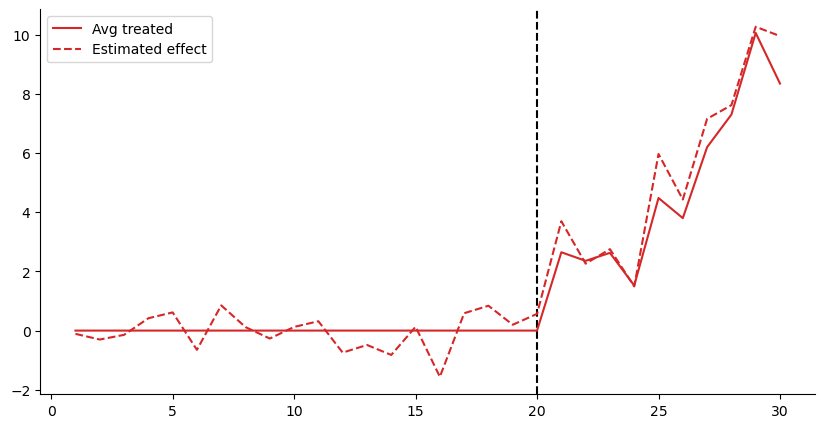

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.axvline(x=T0, color='black', linestyle='--')
ax.plot(eff, color=colors[3], label='Avg treated')
ax.plot(residuals, color=colors[3], linestyle='--', label='Estimated effect')
ax.legend()

sns.despine()